In [1]:
import dataset_utils as dataset

import torch as t

from ML_cup.pytorch import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    torch.set_default_device(torch.device("cuda"))


In [3]:

#column_names = ['ID', 
#                'INPUT_1', 'INPUT_2', 'INPUT_3', 'INPUT_4', 'INPUT_5', 'INPUT_6', 'INPUT_7', 'INPUT_8', 'INPUT_9', 'INPUT_10',
#                'TARGET_x', 'TARGET_y', 'TARGET_z']
#dataframe = pd.read_csv("../data/ML-CUP23-TR.csv", sep=',', comment='#', names=column_names, index_col= 'ID')
#dataframe.head()

dev_data = dataset.load_dataset("../data/ML-CUP23-TR.csv")
blind_data = dataset.load_dataset("../data/ML-CUP23-TS.csv")

In [4]:

# arange the dataset into inputs and labels
from dataset_utils import arrange_datasets, train_val_kfold

X_dev, y_dev, X_blind = arrange_datasets(dev_data, blind_data)
train_folds, val_folds = train_val_kfold(X_dev, y_dev, folds=5, random_state=42)

In [5]:
# Split the dev data into train and validation with k-fold cross validation and minibatch
train_loaders, val_loaders, test_loader = dataset.torch_k_fold(dataset=dev_data, folds=5, batch_size=32)

In [6]:
parameters = [
    {'optimizer': 'SGD', 'lr': [0.01, 0.001, 0.0001], 'weight_decay': [0.0, 0.001, 0.0005], 'momentum': [0.9, 0.75],
     'nesterov': [True, False]}
]
lr_scheduler_params = {'mode': 'min', 'factor': 0.75, 'patience': 5, 'cooldown': 3, 'verbose': False, 'min_lr': 1e-6}

# perform grid search to find the best parameters
best_pytorch_params = grid_search(model_builder=MLP, parameters=parameters, train_loader=train_loaders,
                                  val_loader=val_loaders, scheduler=('ReduceLROnPlateau', lr_scheduler_params),
                                  verbose=False)

/home/alex/.virtualenvs/ML/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 0.08360468879003416, Val Loss: 3.1866790771484377
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 0.03735332251949744, Val Loss: 1.2876408343513805
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': False, 'optimizer': 'SGD'},Train Loss: 0.027728854737837205, Val Loss: 0.41577267696460085
New Best Parameters: {'lr': 0.001, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 0.14932388554919848, Val Loss: 0.3372398853302002
New Best Parameters: {'lr': 0.001, 'weight_decay': 0.0005, 'momentum': 0.9, 'nesterov': False, 'optimizer': 'SGD'},Train Loss: 0.13994245292110877, Val Loss: 0.3190136288603147
Best Parameters: {'lr': 0.001, 'weight_decay': 0.0005, 'momentum': 0.9, 'nesterov': False, 'optimizer': 'SGD'}, Train Loss: 0.139

Fold: 0
Train Epoch: 0 Loss: 388.2272790527344 Val Loss: 78.43319320678711
Train Epoch: 1 Loss: 41.52211486816406 Val Loss: 32.705278396606445
Train Epoch: 2 Loss: 24.253734130859375 Val Loss: 26.465409142630442
Train Epoch: 3 Loss: 20.893029022216798 Val Loss: 25.50482967921666
Train Epoch: 4 Loss: 16.74295570373535 Val Loss: 17.526885781969344
Train Epoch: 5 Loss: 11.528290977478028 Val Loss: 10.280976704188756
Train Epoch: 6 Loss: 6.0144401550292965 Val Loss: 6.560088362012591
Train Epoch: 7 Loss: 4.173069820404053 Val Loss: 5.3077312878199985
Train Epoch: 8 Loss: 3.3089000844955443 Val Loss: 4.118606601442609
Train Epoch: 9 Loss: 2.730620446205139 Val Loss: 3.412374258041382
Train Epoch: 10 Loss: 2.188189134597778 Val Loss: 2.9023473177637373
Train Epoch: 11 Loss: 1.8778166699409484 Val Loss: 2.6254970857075284
Train Epoch: 12 Loss: 1.661795175075531 Val Loss: 2.2843638573374068
Train Epoch: 13 Loss: 1.4853737807273866 Val Loss: 2.1506603956222534
Train Epoch: 14 Loss: 1.3036972069

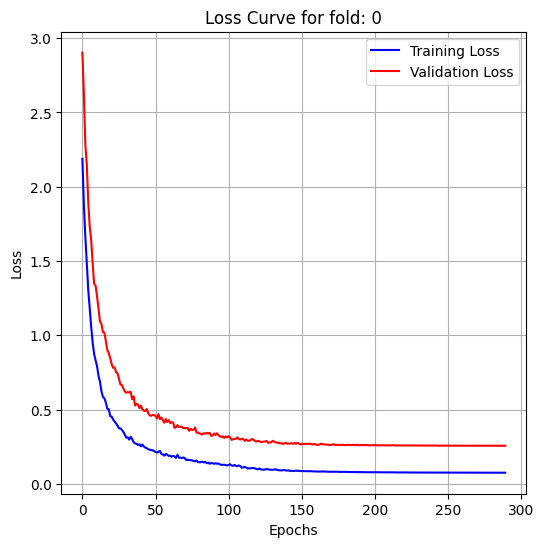

(0.07527806803584099, 0.25683579593896866)

In [7]:
# best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}

# retrain the model with the best parameters
best_model = MLP()
train_loader, val_loader = dataset.torch_split_dataset(dataset=dev_data, train_ratio=0.8, batch_size=32)
if best_pytorch_params['optimizer'] == 'SGD':
    optimizer = t.optim.SGD(best_model.parameters(), lr=best_pytorch_params['lr'],
                            weight_decay=best_pytorch_params['weight_decay'], momentum=best_pytorch_params['momentum'],
                            nesterov=best_pytorch_params['nesterov'])
else:
    optimizer = t.optim.Adam(best_model.parameters(), lr=best_pytorch_params['lr'],
                             weight_decay=best_pytorch_params['weight_decay'])

torch_train(model=best_model, optimizer=optimizer, train_loader=train_loader,
            val_loader=val_loader, epochs=300,
            verbose=True,
            scheduler=lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5, cooldown=3,
                                                     verbose=True, min_lr=1e-6))

In [8]:
# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(best_model, test_loader))

Evaluating the model on the test set
0.42996475100517273


In [9]:
lr_scheduler_params = {'mode': 'min', 'factor': 0.25, 'patience': 10, 'cooldown': 3, 'verbose': False, 'min_lr': 1e-6}

# perform grid search to find the best parameters
best_pytorch_params = grid_search(model_builder=MLP, parameters=parameters, train_loader=train_loaders,
                                  val_loader=val_loaders, scheduler=('ReduceLROnPlateau', lr_scheduler_params),
                                  verbose=False)

New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 0.5636031688106332, Val Loss: 4.814430403709411
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': False, 'optimizer': 'SGD'},Train Loss: 0.14788110368800433, Val Loss: 2.537221258878708
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 0.05006640953943133, Val Loss: 0.8846512277921041
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': False, 'optimizer': 'SGD'},Train Loss: 0.03788341652093963, Val Loss: 0.5545872181653977
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0005, 'momentum': 0.75, 'nesterov': False, 'optimizer': 'SGD'},Train Loss: 0.031439319007437336, Val Loss: 0.32900219187140467
New Best Parameters: {'lr': 0.001, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 0.1456797

Fold: 0
Train Epoch: 0 Loss: 364.1891027832031 Val Loss: 50.55533490862165
Train Epoch: 1 Loss: 34.846002349853514 Val Loss: 26.250003814697266
Train Epoch: 2 Loss: 24.0945809173584 Val Loss: 22.2394289289202
Train Epoch: 3 Loss: 17.530341796875 Val Loss: 12.332779475620814
Train Epoch: 4 Loss: 7.887577810287476 Val Loss: 5.837116922651019
Train Epoch: 5 Loss: 4.734234075546265 Val Loss: 4.439782891954694
Train Epoch: 6 Loss: 3.573203525543213 Val Loss: 3.480448705809457
Train Epoch: 7 Loss: 2.8494939661026 Val Loss: 3.1615841559001376
Train Epoch: 8 Loss: 2.398571856021881 Val Loss: 2.676927242960249
Train Epoch: 9 Loss: 2.0127871894836424 Val Loss: 2.456616061074393
Train Epoch: 10 Loss: 1.756067671775818 Val Loss: 2.1357194781303406
Train Epoch: 11 Loss: 1.5402692079544067 Val Loss: 1.9757716144834245
Train Epoch: 12 Loss: 1.3655116748809815 Val Loss: 1.8366158860070365
Train Epoch: 13 Loss: 1.2211724281311036 Val Loss: 1.7180845992905753
Train Epoch: 14 Loss: 1.0869455385208129 Val

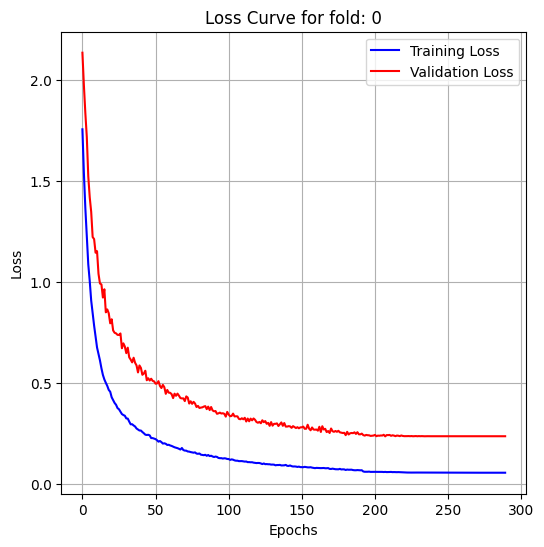

(0.053723148554563525, 0.23456796471561706)

In [10]:
# changed scheduler compared to the previous cell, added nesterov
best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}

# retrain the model with the best parameters
best_model = MLP()
train_loader, val_loader = dataset.torch_split_dataset(dataset=dev_data, train_ratio=0.8, batch_size=32)
if best_pytorch_params['optimizer'] == 'SGD':
    optimizer = t.optim.SGD(best_model.parameters(), lr=best_pytorch_params['lr'],
                            weight_decay=best_pytorch_params['weight_decay'], momentum=best_pytorch_params['momentum'],
                            nesterov=best_pytorch_params['nesterov'])
else:
    optimizer = t.optim.Adam(best_model.parameters(), lr=best_pytorch_params['lr'],
                             weight_decay=best_pytorch_params['weight_decay'])

torch_train(model=best_model, optimizer=optimizer, train_loader=train_loader,
            val_loader=val_loader, epochs=300,
            verbose=True,
            scheduler=lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=10, cooldown=3,
                                                     verbose=True, min_lr=1e-6))

In [11]:
# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(best_model, test_loader))

Evaluating the model on the test set
0.36167827248573303


In [9]:
'''test_loader = DataLoader(CupDataset(blind_data))

# plot twist, it's only the inputs

# Evaluate the trained model on the test set
model = best_model
model.eval()  # Set the model to evaluation mode

outputs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        output = model(inputs)
        outputs.append(output)

outputs'''

"test_loader = DataLoader(CupDataset(blind_data))\n\n# plot twist, it's only the inputs\n\n# Evaluate the trained model on the test set\nmodel = best_model\nmodel.eval()  # Set the model to evaluation mode\n\noutputs = []\nwith torch.no_grad():\n    for inputs, labels in test_loader:\n        output = model(inputs)\n        outputs.append(output)\n\noutputs"